In [16]:
import pandas as pd

In [17]:
df_test = pd.read_table("/mnt/nfs/wangd/DeepLC/non_ions6_format.tsv",sep = ",")
df_test.sort_values("tr",inplace=True)
#df_test.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_test = df_test.groupby(["seq","modifications"], as_index=False).median()

In [18]:
df_test

,seq,modifications,PSM_ID,unique,database_version,search_engine_score[1],retention_time,charge,exp_mass_to_charge,calc_mass_to_charge,opt_global_Posterior_Error_Probability_score,opt_global_q-value,opt_global_cv_MS:1002217_decoy_peptide,target,FDR,q-value,ScanNum,annotater_ions_number,tr
0,AAANFFSASCVPCADQSSFPK,0|TMT6plex|10|Carbamidomethyl|13|Carbamidometh...,105032.5,0.0,NaN,0.000018,3495.20000,3.5,794.141850,794.140531,0.000017,0.000000,0.0,1.0,0.000635,0.000330,21157.5,52.5,3495.20000
1,AAILVTPLLK,0|TMT6plex|10|TMT6plex,100824.0,0.0,NaN,0.066782,3375.40000,2.0,749.011352,749.012645,0.956271,0.177222,1.0,0.0,0.009577,0.009577,20681.0,17.0,3375.40000
2,AATLSTLAGQPLLER,0|TMT6plex,96418.0,1.0,NaN,0.000018,3265.90000,2.0,885.519449,885.519775,0.000014,0.000000,0.0,1.0,0.000378,0.000330,19634.0,28.0,3265.90000
3,AAVTSLFAK,0|TMT6plex|9|TMT6plex,90871.5,1.0,NaN,0.000049,3118.20000,2.5,569.692168,569.692001,0.001024,0.000000,0.0,1.0,0.000479,0.000330,18864.5,20.0,3118.20000
4,AEATESAMEK,0|TMT6plex|10|TMT6plex,34688.0,0.0,NaN,0.000034,1721.40000,2.5,635.920470,635.920073,0.000220,0.000000,0.0,1.0,0.000669,0.000330,9651.5,24.0,1721.40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,YNSESPSK,0|TMT6plex|8|TMT6plex,19756.0,1.0,NaN,0.000058,1276.43214,2.0,685.871887,685.371825,0.001739,0.000000,0.0,1.0,0.000385,0.000330,6762.0,16.0,1276.43214
376,YPHSLQHHVHCCSRPICRGSSIWYRHFWLIRLCSASCCQF,0|TMT6plex|11|Carbamidomethyl|12|Carbamidometh...,135226.0,0.0,NaN,0.072869,4413.79080,4.0,1347.890259,1347.888464,1.000000,0.066533,0.0,1.0,0.001775,0.001775,27513.0,14.0,4413.79080
377,YVQIGSDSRDGKCLYEKCLGSDPKWEYSKCQQRDPDTK,12|TMT6plex|13|Carbamidomethyl|17|TMT6plex|18|...,139393.0,0.0,NaN,0.072869,5091.96180,4.0,1264.620605,1264.616448,1.000000,0.059983,1.0,0.0,0.001204,0.001204,31307.0,6.0,5091.96180
378,YWSQQIEVSTTVATTQSTEVGAAEMTLTELR,0|TMT6plex,146316.0,1.0,NaN,0.000077,4547.90520,3.0,1220.618957,1220.615254,0.002969,0.000000,0.0,1.0,0.000488,0.000330,28393.0,45.0,4547.90520


In [19]:
df_train = pd.read_csv("/mnt/nfs/wangd/DeepLC/can.csv")
df_train.sort_values("tr",inplace=True)
#df_train.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_train = df_train.groupby(["seq","modifications"], as_index=False).median()

In [20]:
# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

In [21]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

### full_hc_train_pxd001468 Calibration

In [22]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

2023-03-14 11:19:09.597842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Error.  nthreads must be a positive integer2023-03-14 11:19:13.972070: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-14 11:19:14.381477: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 101856960 exceeds 10% of free system memory.
2023-03-14 11:19:14.448929: 

14/14 [==============================] - 16s 1s/step


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

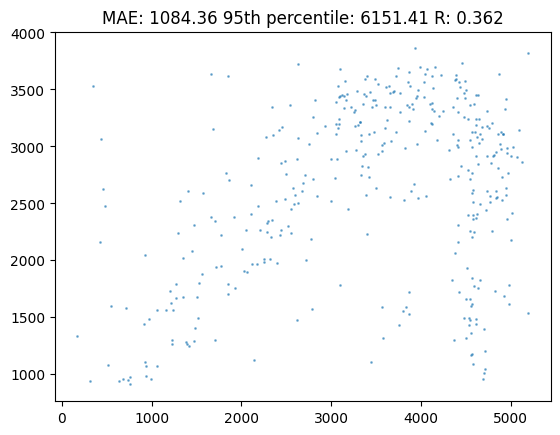

In [23]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.show()

### full_hc_hela_hf_psms_aligned Calibration

In [24]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

2023-03-14 11:21:54.215341: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 16s 1s/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_17824'.


14/14 [==============================] - 16s 1s/step


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

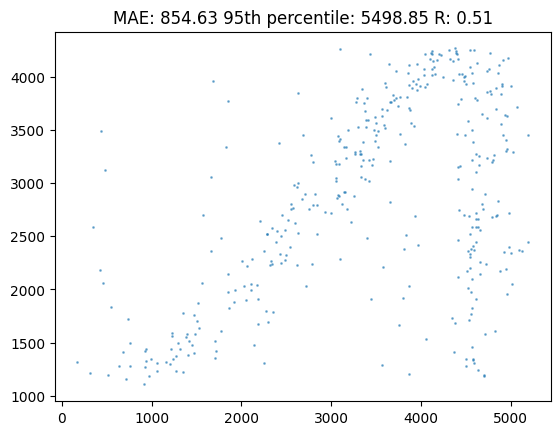

In [25]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.show()

### Transfer learning with full_hc_train_pxd001468 models

In [26]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    freeze_layers=False,
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

2023-03-14 11:24:55.599985: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    p

Epoch 1/50
473/473 [==============================] - 46s 94ms/step - loss: 0.2428 - mean_absolute_error: 0.2100 - val_loss: 0.3005 - val_mean_absolute_error: 0.2681
Epoch 2/50
473/473 [==============================] - 43s 91ms/step - loss: 0.1833 - mean_absolute_error: 0.1513 - val_loss: 0.1927 - val_mean_absolute_error: 0.1611
Epoch 3/50
473/473 [==============================] - 43s 91ms/step - loss: 0.1674 - mean_absolute_error: 0.1360 - val_loss: 0.2082 - val_mean_absolute_error: 0.1770
Epoch 4/50
473/473 [==============================] - 43s 91ms/step - loss: 0.1627 - mean_absolute_error: 0.1318 - val_loss: 0.1657 - val_mean_absolute_error: 0.1350
Epoch 5/50
473/473 [==============================] - 45s 94ms/step - loss: 0.1646 - mean_absolute_error: 0.1340 - val_loss: 0.1657 - val_mean_absolute_error: 0.1354
Epoch 6/50
473/473 [==============================] - 45s 94ms/step - loss: 0.1572 - mean_absolute_error: 0.1271 - val_loss: 0.1762 - val_mean_absolute_error: 0.1462
Epoc

473/473 [==============================] - 45s 95ms/step - loss: 0.1029 - mean_absolute_error: 0.0805 - val_loss: 0.1202 - val_mean_absolute_error: 0.0978
Epoch 1/50
473/473 [==============================] - 66s 137ms/step - loss: 0.2750 - mean_absolute_error: 0.2316 - val_loss: 0.2627 - val_mean_absolute_error: 0.2205
Epoch 2/50
473/473 [==============================] - 56s 119ms/step - loss: 0.2028 - mean_absolute_error: 0.1609 - val_loss: 0.2001 - val_mean_absolute_error: 0.1585
Epoch 3/50
473/473 [==============================] - 62s 131ms/step - loss: 0.1856 - mean_absolute_error: 0.1445 - val_loss: 0.1872 - val_mean_absolute_error: 0.1464
Epoch 4/50
473/473 [==============================] - 56s 119ms/step - loss: 0.1782 - mean_absolute_error: 0.1378 - val_loss: 0.1622 - val_mean_absolute_error: 0.1221
Epoch 5/50
473/473 [==============================] - 61s 129ms/step - loss: 0.1714 - mean_absolute_error: 0.1315 - val_loss: 0.1718 - val_mean_absolute_error: 0.1323
Epoch 6/50

Epoch 49/50
473/473 [==============================] - 51s 108ms/step - loss: 0.1160 - mean_absolute_error: 0.0884 - val_loss: 0.1382 - val_mean_absolute_error: 0.1110
Epoch 50/50
473/473 [==============================] - 51s 108ms/step - loss: 0.1103 - mean_absolute_error: 0.0833 - val_loss: 0.1315 - val_mean_absolute_error: 0.1047
Epoch 1/50
473/473 [==============================] - 71s 148ms/step - loss: 0.3787 - mean_absolute_error: 0.3166 - val_loss: 0.2853 - val_mean_absolute_error: 0.2258
Epoch 2/50
473/473 [==============================] - 70s 148ms/step - loss: 0.2618 - mean_absolute_error: 0.2036 - val_loss: 0.2874 - val_mean_absolute_error: 0.2302
Epoch 3/50
473/473 [==============================] - 71s 150ms/step - loss: 0.2455 - mean_absolute_error: 0.1891 - val_loss: 0.2767 - val_mean_absolute_error: 0.2211
Epoch 4/50
473/473 [==============================] - 70s 147ms/step - loss: 0.2283 - mean_absolute_error: 0.1734 - val_loss: 0.2407 - val_mean_absolute_error: 0.1

Epoch 48/50
473/473 [==============================] - 132s 279ms/step - loss: 0.1385 - mean_absolute_error: 0.1029 - val_loss: 0.1756 - val_mean_absolute_error: 0.1407
Epoch 49/50
473/473 [==============================] - 129s 273ms/step - loss: 0.1455 - mean_absolute_error: 0.1092 - val_loss: 0.1597 - val_mean_absolute_error: 0.1234
Epoch 50/50
473/473 [==============================] - 117s 248ms/step - loss: 0.1357 - mean_absolute_error: 0.1002 - val_loss: 0.1570 - val_mean_absolute_error: 0.1216


2023-03-14 13:56:43.123189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-14 13:56:51.453169: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.454424: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.454619: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.455588: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not ret

2023-03-14 13:56:51.886257: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.888261: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.937726: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.938815: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.972447: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 13:56:51.974198: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: i

14/14 [==============================] - 19s 1s/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_38538'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/t

    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_99855'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remo

14/14 [==============================] - 16s 1s/step


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

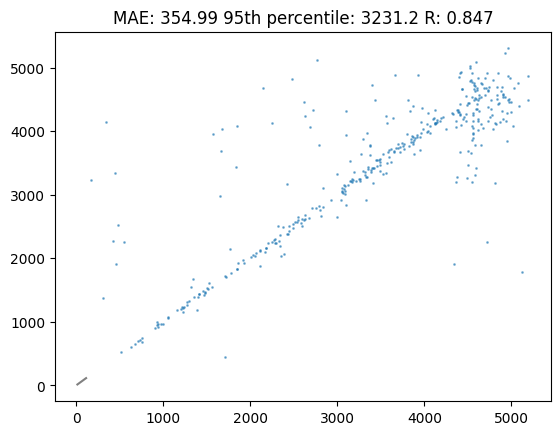

In [27]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

### Transfer learning with full_hc_hela_hf_psms_aligned models

In [28]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    freeze_layers=False,
    n_epochs=10,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

2023-03-14 14:01:24.210365: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    p

Epoch 1/10
473/473 [==============================] - 73s 152ms/step - loss: 0.1828 - mean_absolute_error: 0.1577 - val_loss: 0.1949 - val_mean_absolute_error: 0.1703
Epoch 2/10
473/473 [==============================] - 70s 148ms/step - loss: 0.1378 - mean_absolute_error: 0.1138 - val_loss: 0.1533 - val_mean_absolute_error: 0.1296
Epoch 3/10
473/473 [==============================] - 80s 169ms/step - loss: 0.1252 - mean_absolute_error: 0.1018 - val_loss: 0.1332 - val_mean_absolute_error: 0.1101
Epoch 4/10
473/473 [==============================] - 66s 140ms/step - loss: 0.1192 - mean_absolute_error: 0.0962 - val_loss: 0.1328 - val_mean_absolute_error: 0.1100
Epoch 5/10
473/473 [==============================] - 79s 167ms/step - loss: 0.1157 - mean_absolute_error: 0.0930 - val_loss: 0.1309 - val_mean_absolute_error: 0.1083
Epoch 6/10
473/473 [==============================] - 87s 183ms/step - loss: 0.1149 - mean_absolute_error: 0.0924 - val_loss: 0.1345 - val_mean_absolute_error: 0.112

2023-03-14 14:40:15.699706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 18s 1s/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_train_function_268761'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorfl

14/14 [==============================] - 16s 1s/step


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

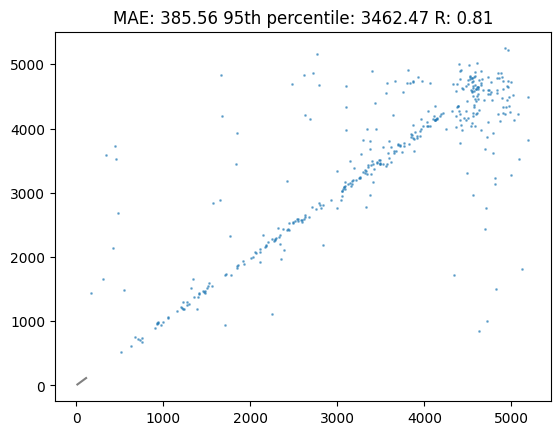

In [29]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

### Transfer learning with hela models(500<tr<4500)

In [30]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

df_train = df_train[(500< df_train["tr"]) & (df_train["tr"]< 4500)]
df_test = df_test[(500< df_test["tr"]) & (df_test["tr"]< 4500)]

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)2023-03-14 14:43:55.695141: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    cont

Epoch 1/50
468/468 [==============================] - 48s 99ms/step - loss: 0.1849 - mean_absolute_error: 0.1599 - val_loss: 0.1429 - val_mean_absolute_error: 0.1184
Epoch 2/50
468/468 [==============================] - 43s 92ms/step - loss: 0.1434 - mean_absolute_error: 0.1193 - val_loss: 0.1706 - val_mean_absolute_error: 0.1469
Epoch 3/50
468/468 [==============================] - 43s 92ms/step - loss: 0.1301 - mean_absolute_error: 0.1066 - val_loss: 0.1386 - val_mean_absolute_error: 0.1153
Epoch 4/50
468/468 [==============================] - 44s 93ms/step - loss: 0.1221 - mean_absolute_error: 0.0992 - val_loss: 0.1356 - val_mean_absolute_error: 0.1129
Epoch 5/50
468/468 [==============================] - 43s 93ms/step - loss: 0.1195 - mean_absolute_error: 0.0968 - val_loss: 0.1438 - val_mean_absolute_error: 0.1213
Epoch 6/50
468/468 [==============================] - 42s 89ms/step - loss: 0.1156 - mean_absolute_error: 0.0931 - val_loss: 0.1223 - val_mean_absolute_error: 0.1000
Epoc

468/468 [==============================] - 43s 91ms/step - loss: 0.0872 - mean_absolute_error: 0.0676 - val_loss: 0.1041 - val_mean_absolute_error: 0.0845
Epoch 1/50
468/468 [==============================] - 63s 131ms/step - loss: 0.1761 - mean_absolute_error: 0.1452 - val_loss: 0.1359 - val_mean_absolute_error: 0.1055
Epoch 2/50
468/468 [==============================] - 58s 124ms/step - loss: 0.1373 - mean_absolute_error: 0.1077 - val_loss: 0.1512 - val_mean_absolute_error: 0.1222
Epoch 3/50
468/468 [==============================] - 56s 120ms/step - loss: 0.1284 - mean_absolute_error: 0.0996 - val_loss: 0.1338 - val_mean_absolute_error: 0.1054
Epoch 4/50
468/468 [==============================] - 59s 125ms/step - loss: 0.1227 - mean_absolute_error: 0.0945 - val_loss: 0.1209 - val_mean_absolute_error: 0.0927
Epoch 5/50
468/468 [==============================] - 55s 117ms/step - loss: 0.1203 - mean_absolute_error: 0.0923 - val_loss: 0.1209 - val_mean_absolute_error: 0.0933
Epoch 6/50

Epoch 49/50
468/468 [==============================] - 55s 118ms/step - loss: 0.0879 - mean_absolute_error: 0.0656 - val_loss: 0.1013 - val_mean_absolute_error: 0.0790
Epoch 50/50
468/468 [==============================] - 59s 125ms/step - loss: 0.0839 - mean_absolute_error: 0.0617 - val_loss: 0.1212 - val_mean_absolute_error: 0.0989
Epoch 1/50
468/468 [==============================] - 86s 180ms/step - loss: 1.0534 - mean_absolute_error: 0.9880 - val_loss: 0.5175 - val_mean_absolute_error: 0.4582
Epoch 2/50
468/468 [==============================] - 77s 165ms/step - loss: 0.4660 - mean_absolute_error: 0.4109 - val_loss: 0.3930 - val_mean_absolute_error: 0.3413
Epoch 3/50
468/468 [==============================] - 76s 162ms/step - loss: 0.3888 - mean_absolute_error: 0.3388 - val_loss: 0.3180 - val_mean_absolute_error: 0.2692
Epoch 4/50
468/468 [==============================] - 78s 167ms/step - loss: 0.3448 - mean_absolute_error: 0.2969 - val_loss: 0.2874 - val_mean_absolute_error: 0.2

Epoch 48/50
468/468 [==============================] - 73s 156ms/step - loss: 0.1215 - mean_absolute_error: 0.0958 - val_loss: 0.1307 - val_mean_absolute_error: 0.1050
Epoch 49/50
468/468 [==============================] - 69s 148ms/step - loss: 0.1251 - mean_absolute_error: 0.0994 - val_loss: 0.1282 - val_mean_absolute_error: 0.1026
Epoch 50/50
468/468 [==============================] - 70s 149ms/step - loss: 0.1194 - mean_absolute_error: 0.0939 - val_loss: 0.1292 - val_mean_absolute_error: 0.1039


2023-03-14 17:15:38.495027: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.495015: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.495017: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.495564: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.497371: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.498035: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: i

2023-03-14 17:15:38.906154: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.907720: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.916227: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:38.917727: E tensorflow/stream_executor/cuda/cuda_driver.cc:1274] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-03-14 17:15:39.496626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

14/14 [==============================] - 15s 1s/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_420480'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f31f8caa158>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/

14/14 [==============================] - 17s 1s/step


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

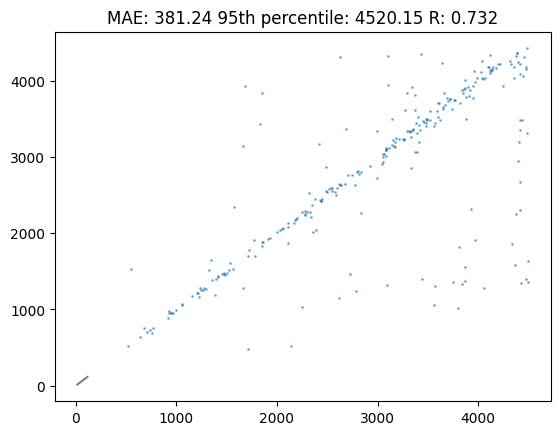

In [31]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()